# Visualising a gravitational-wave signal

In this notebook, I will use some Python code to:

* get raw gravitational wave data around the black hole merger event GW150914 (the first event seen on 14th September 2015);
* plot the "raw" data;
* plot the spectra of the raw data;
* filter the data to reveal the signal;
* create a "spectrogram" of the data to reveal the signals time-frequency structure;
* calculate the signal-to-noise ratio

This will use the Python packages [GWPy](https://gwpy.github.io/), [GWOSC](https://gwosc.readthedocs.io/) and [PyCBC](http://pycbc.org/pycbc/latest/html/index.html) and use open data from the [Gravitational-Wave Open Science Center](https://www.gw-openscience.org/). This is heavily based on the tutorial given [here](https://github.com/losc-tutorial/quickview), the GWPy example [here](https://gwpy.github.io/docs/stable/examples/timeseries/public/) and the PyCBC example [here](http://pycbc.org/pycbc/latest/html/gw150914.html). A very nice interactive App that can be used to do some of this via a web interface is [here](https://share.streamlit.io/jkanner/streamlit-dataview/master/app.py/+/).

In [1]:
%matplotlib inline

# import the required modules
from gwosc.datasets import event_gps  # get the time of a known named event
from gwpy.timeseries import TimeSeries, TimeSeriesDict  # for reading in and displaying the data

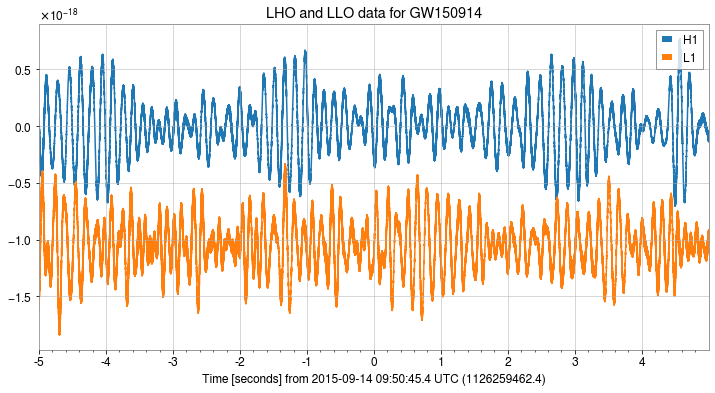

In [12]:
eventname = "GW150914"  # the first gravitational-wave event!

# get the time of the event
t0 = event_gps(eventname)

# get +/-5 seconds of data around the event for the LIGO Hanford detector
#dataH1.read("H1_GW150914.hdf5")  # back-up in case of no internet access
dataH1 = TimeSeries.fetch_open_data("H1", t0 - 5, t0 + 5)
#dataH1.write("H1_GW150914.hdf5")

# get +/-5 seconds of data around the event for the LIGO Livingston detector
#dataL1.read("L1_GW150914.hdf5")  # back-up in case of no internet access
dataL1 = TimeSeries.fetch_open_data("L1", t0 - 5, t0 + 5)
#dataL1.write("L1_GW150914.hdf5")

data = TimeSeriesDict()  # put both data sets into a dictionary
data["H1"] = dataH1
data["L1"] = dataL1

# plot the raw data
plot = data.plot(epoch=t0, title="LHO and LLO data for GW150914")
plot.gca().legend(loc="upper right");

(1e-24, 2e-19)

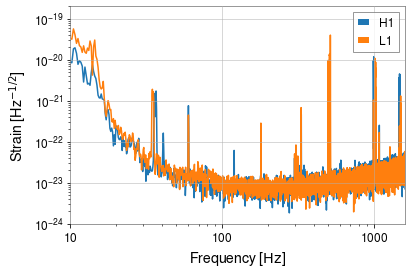

In [3]:
# plot the spectra (i.e., the frequency content) of the data
specH1 = dataH1.asd(fftlength=4)
specL1 = dataL1.asd(fftlength=4)

plot = specH1.plot(label="H1")
ax = plot.gca()
ax.plot(specL1, label="L1")
ax.set_ylabel("Strain [Hz$^{-1/2}$]")
ax.legend()
ax.set_xlim([10, 1600])
ax.set_ylim([1e-24, 2e-19]);

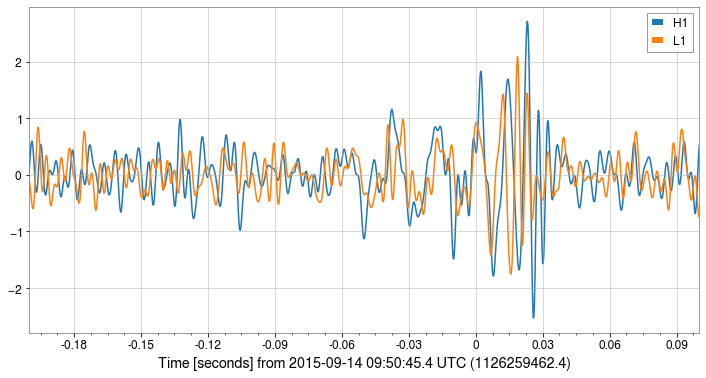

In [4]:
# whiten and filter the data
filtereddata = TimeSeriesDict()

# filter out noise below 35 Hz and above 300 Hz
filtereddata["H1"] = dataH1.whiten().bandpass(35, 300)
filtereddata["L1"] = dataL1.whiten().bandpass(35, 300)

# plot the filtered data
plot = filtereddata.plot(epoch=t0)
ax = plot.gca()
ax.legend(loc="upper right")
ax.set_xlim([t0 - 0.2, t0 + 0.1]);  # zoom in on signal

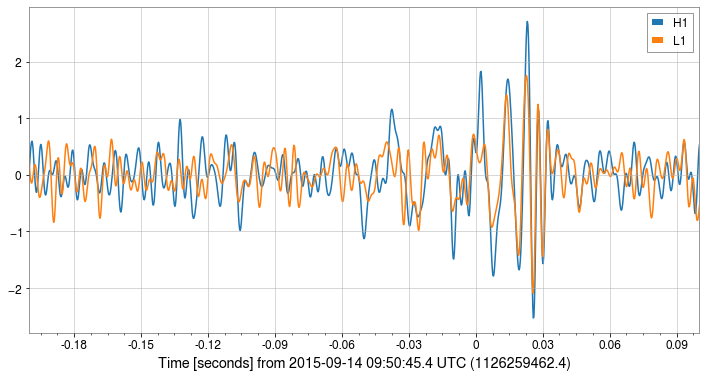

In [5]:
# time shift and flip L1 data
filtereddataL1 = -1.0 * dataL1.whiten().bandpass(35, 300)
filtereddataL1.shift(0.007)  # shift by 0.007 seconds due to GW travel time between detectors

filtereddata["L1"] = filtereddataL1

# plot the filtered data
plot = filtereddata.plot(epoch=t0)
ax = plot.gca()
ax.legend(loc="upper right")
ax.set_xlim([t0 - 0.2, t0 + 0.1]);  # zoom in on signal

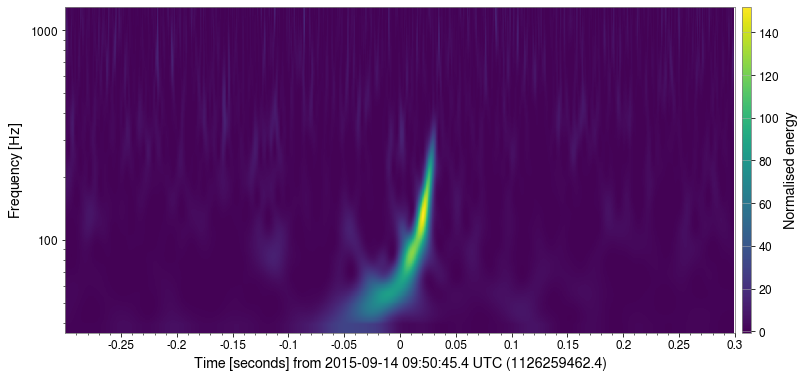

In [6]:
# plot a "spectrogram" (in this case actually a Q-transform) for the unfiltered H1 data
dt = 0.3  # use +/-0.3 second around the signal
hq = dataH1.q_transform(outseg=(t0 - dt, t0 + dt))
plot = hq.plot(epoch=t0)
ax = plot.gca()
plot.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale("log")

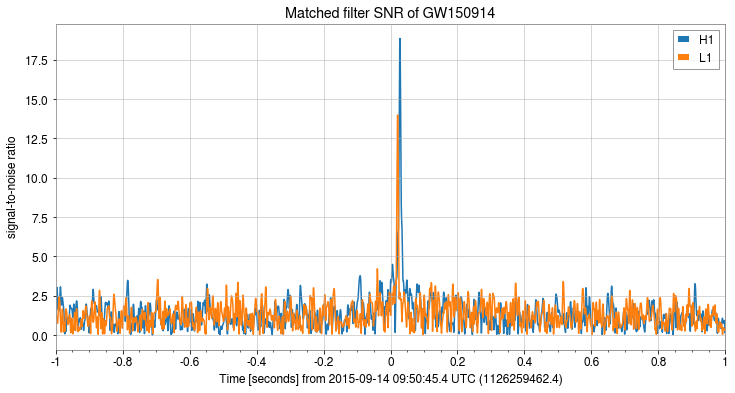

In [10]:
# get the signal-to-noise ratio
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.filter import matched_filter

# filter and convert to PyCBC TimeSeries objects
pycbcdataH1 = dataH1.bandpass(15, 1500).to_pycbc()
pycbcdataL1 = dataL1.bandpass(15, 1500).to_pycbc()

# generate PSDs
psdH1 = interpolate(welch(pycbcdataH1), 1.0 / pycbcdataH1.duration)
psdL1 = interpolate(welch(pycbcdataL1), 1.0 / pycbcdataL1.duration)

# generate a template (model gravitational-waveform) to filter against
hp, hc = get_fd_waveform(
    approximant="IMRPhenomD",
    mass1=40,  # one 40 solar mass black hole
    mass2=32,  # one 32 solar mass black hole
    f_lower=20,
    delta_f=(1.0 / pycbcdataH1.duration),
)
hp.resize(len(pycbcdataH1) // 2 + 1)

# filter the template against the data
snrH1 = matched_filter(hp, pycbcdataH1, psd=psdH1, low_frequency_cutoff=20.0)
snrH1 = snrH1[len(snrH1) // 4: len(snrH1) * 3 // 4]

snrL1 = matched_filter(hp, pycbcdataL1, psd=psdL1, low_frequency_cutoff=20.0)
snrL1 = snrL1[len(snrL1) // 4: len(snrL1) * 3 // 4]

# plot the signal-to-noise ratio time series
snrts = TimeSeriesDict()
snrts["H1"] = TimeSeries.from_pycbc(abs(snrH1))
snrts["L1"] = TimeSeries.from_pycbc(abs(snrL1))

plot = snrts.plot(epoch=t0, title="Matched filter SNR of GW150914")
ax = plot.gca()
ax.legend(loc="upper right")
ax.set_xlim([t0 - 1.0, t0 + 1.0])
ax.set_ylabel("signal-to-noise ratio");